In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/data")

#{"username":"ayhantan","key":"589e2a6702e67408b3a66abc2d2f11a5"}

Skipping, found downloaded files in "./cards-image-datasetclassification" (use force=True to force download)


In [ ]:
import pandas as pd
data = pd.read_csv("/content/cards-image-datasetclassification/cards.csv")

In [ ]:
data.head()

class index                   filepaths        labels card type data set
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train

In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
sns.set_style('darkgrid')

from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense,Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

uploaded = files.upload()

print("Load Models")

Saving imagee.jpg to imagee.jpg
Load Models


In [ ]:
class DataPreprocessing:

    def readData(path):
        filepaths = []
        labels = []

        folds = os.listdir(path)
        for fold in folds:
            foldpaths = os.path.join(path,fold)
            filelists = os.listdir(foldpaths)

            for file in filelists:
                filepath = os.path.join(foldpaths,file)

                filepaths.append(filepath)
                labels.append(fold)

        Fseries = pd.Series(filepaths, name="filepath")
        Lseries = pd.Series(labels, name="label")

        df = pd.concat([Fseries, Lseries], axis=1)

        return df

    def CreateImageDataGenerator(train_df, valid_df, test_df):
        image_size = (224, 224)
        batch_size = 20

        # Create an ImageDataGenerator for training with data augmentation
        train_gen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        ).flow_from_dataframe(train_df, x_col="filepath", y_col="label", color_mode='rgb',
                              class_mode="categorical", batch_size=batch_size, target_size=image_size)

        # Create an ImageDataGenerator for validation and test without augmentation
        valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col="filepath", y_col="label", color_mode='rgb',
                                                              class_mode="categorical", batch_size=batch_size, target_size=image_size)

        test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col="filepath", y_col="label", color_mode='rgb',
                                                             class_mode="categorical", batch_size=batch_size, target_size=image_size)

        return train_gen, valid_gen, test_gen


    def show_sample_of_data(data_gen):
        gen_dict = data_gen.class_indices
        classes_name = list(gen_dict.keys())

        images, labels = next(train_gen)


        plt.figure(figsize= (20, 20))

        for i in range(16):
            plt.subplot(4, 4, i + 1)
            image = images[i] / 255       # scales data to range (0 - 255)
            plt.imshow(image)
            index = np.argmax(labels[i])  # get image index
            class_name = classes_name[index]   # get class of image
            plt.title(class_name, color= 'blue', fontsize= 20)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
train_df = DataPreprocessing.readData("/content/cards-image-datasetclassification/train")
train_df.head()

filepath           label
0  /content/cards-image-datasetclassification/tra...  five of hearts
1  /content/cards-image-datasetclassification/tra...  five of hearts
2  /content/cards-image-datasetclassification/tra...  five of hearts
3  /content/cards-image-datasetclassification/tra...  five of hearts
4  /content/cards-image-datasetclassification/tra...  five of hearts

In [ ]:
valid_df = DataPreprocessing.readData("/content/cards-image-datasetclassification/valid")
valid_df.head()

filepath           label
0  /content/cards-image-datasetclassification/val...  five of hearts
1  /content/cards-image-datasetclassification/val...  five of hearts
2  /content/cards-image-datasetclassification/val...  five of hearts
3  /content/cards-image-datasetclassification/val...  five of hearts
4  /content/cards-image-datasetclassification/val...  five of hearts

In [ ]:
test_df = DataPreprocessing.readData("/content/cards-image-datasetclassification/test")
test_df.head()

filepath           label
0  /content/cards-image-datasetclassification/tes...  five of hearts
1  /content/cards-image-datasetclassification/tes...  five of hearts
2  /content/cards-image-datasetclassification/tes...  five of hearts
3  /content/cards-image-datasetclassification/tes...  five of hearts
4  /content/cards-image-datasetclassification/tes...  five of hearts

In [ ]:
train_gen, valid_gen, test_gen = DataPreprocessing.CreateImageDataGenerator(train_df,valid_df,test_df)

Found 7624 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.


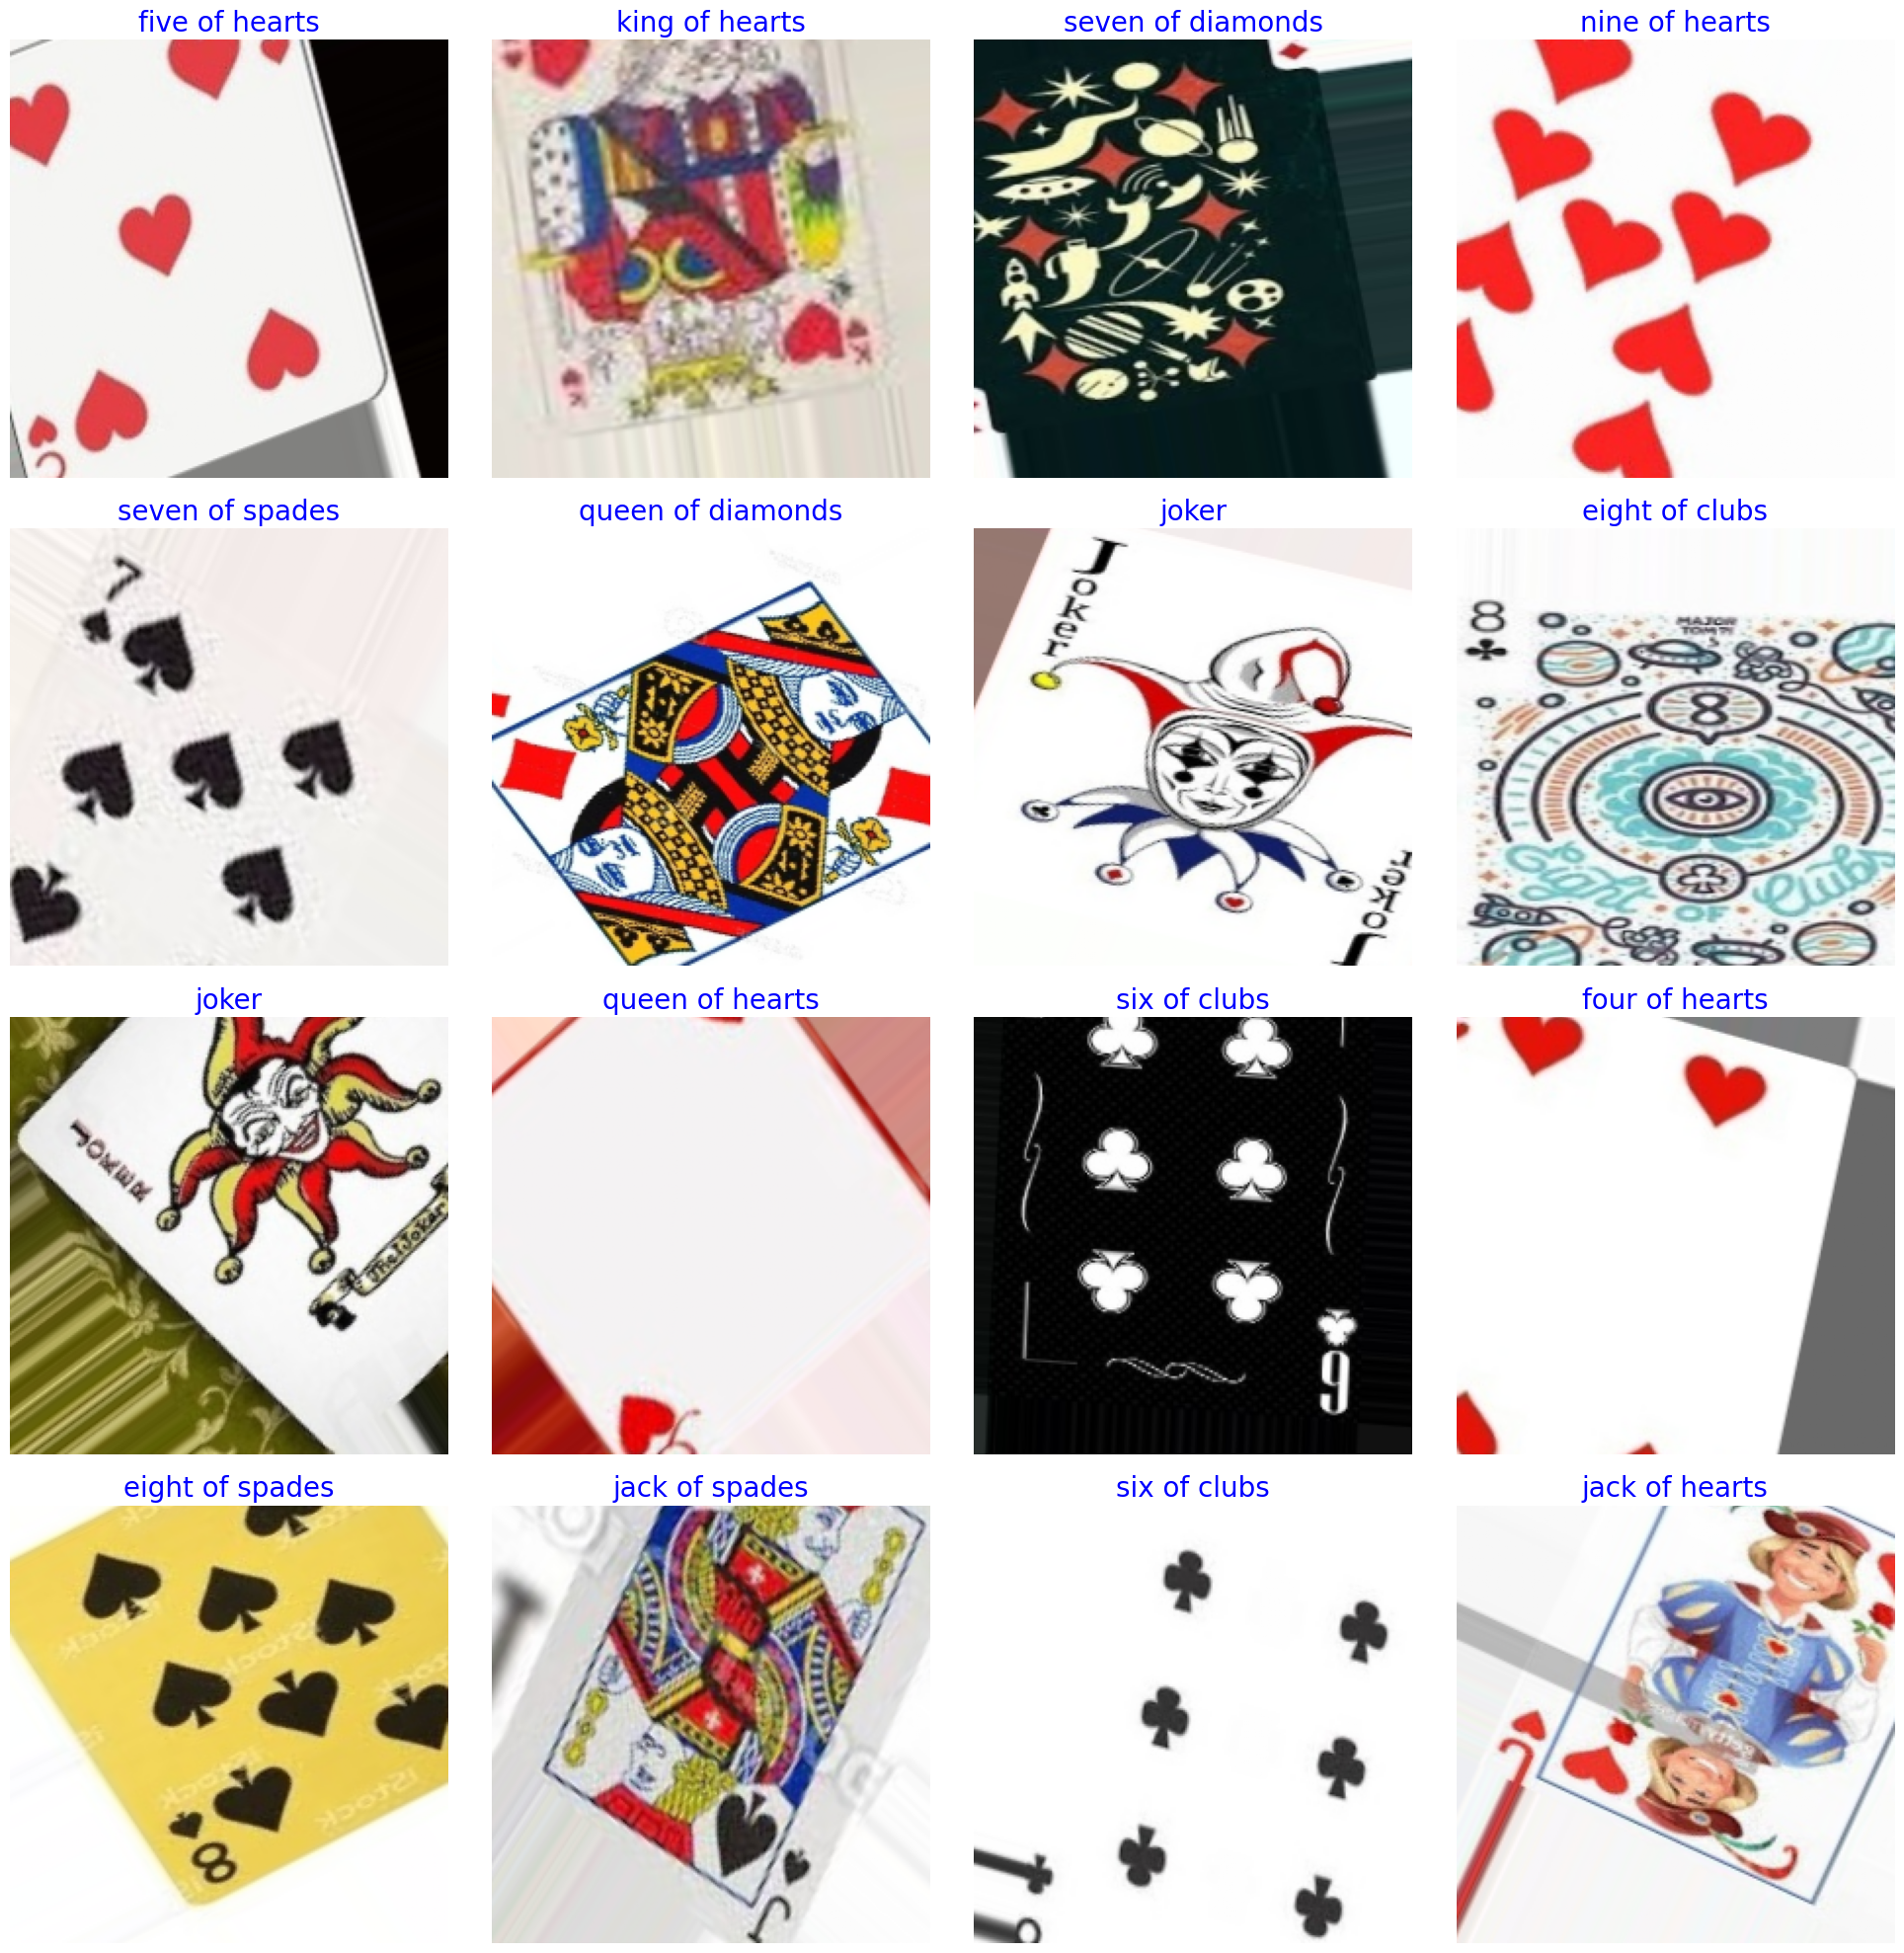

In [ ]:
#Show sample of train data
DataPreprocessing.show_sample_of_data(train_gen)

In [ ]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

"""#EfficientNetB7
base_model = keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
)

base_model.trainable = True
"""

#RestNet50
base_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
)

base_model.trainable = False  # Set to True and fine-tune later if desired
"""
#MobileNetV2
base_model = keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
)

base_model.trainable = False  # Or True if you want fine-tuning
"""



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


'\n#MobileNetV2\nbase_model = keras.applications.MobileNetV2(\n    include_top=False,\n    weights="imagenet",\n    input_shape=image_shape,\n)\n\nbase_model.trainable = False  # Or True if you want fine-tuning\n'

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  175


In [ ]:
inputs = keras.Input(image_shape)
x = base_model(inputs)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(rate=0.1, seed=123)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(rate=0.2, seed=123)(x)
outputs = keras.layers.Dense(class_count,activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,444,597 (139.03 MB)

 Trainable params: 12,856,885 (49.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_gen, epochs= 20, verbose= 1,
                    validation_data = valid_gen, callbacks=[early_stopping], shuffle= False)

Epoch 1/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 132s 292ms/step - accuracy: 0.0372 - loss: 4.0311 - val_accuracy: 0.1283 - val_loss: 3.4770
Epoch 2/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 97s 254ms/step - accuracy: 0.0811 - loss: 3.6641 - val_accuracy: 0.1660 - val_loss: 3.1550
Epoch 3/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 98s 258ms/step - accuracy: 0.1281 - loss: 3.4566 - val_accuracy: 0.2075 - val_loss: 2.9867
Epoch 4/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 97s 253ms/step - accuracy: 0.1593 - loss: 3.2990 - val_accuracy: 0.2415 - val_loss: 2.7533
Epoch 5/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 98s 257ms/step - accuracy: 0.1882 - loss: 3.1320 - val_accuracy: 0.2679 - val_loss: 2.5902
Epoch 6/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 98s 257ms/step - accuracy: 0.2000 - loss: 3.0409 - val_accuracy: 0.3358 - val_loss: 2.3954
Epoch 7/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 97s 255ms/step - accuracy: 0.2266 - loss: 2.9206 - val_accuracy: 0.3434 - val_loss: 2.3026
Epoch 8/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 97s 255ms/step - accuracy: 0.2362 - loss: 

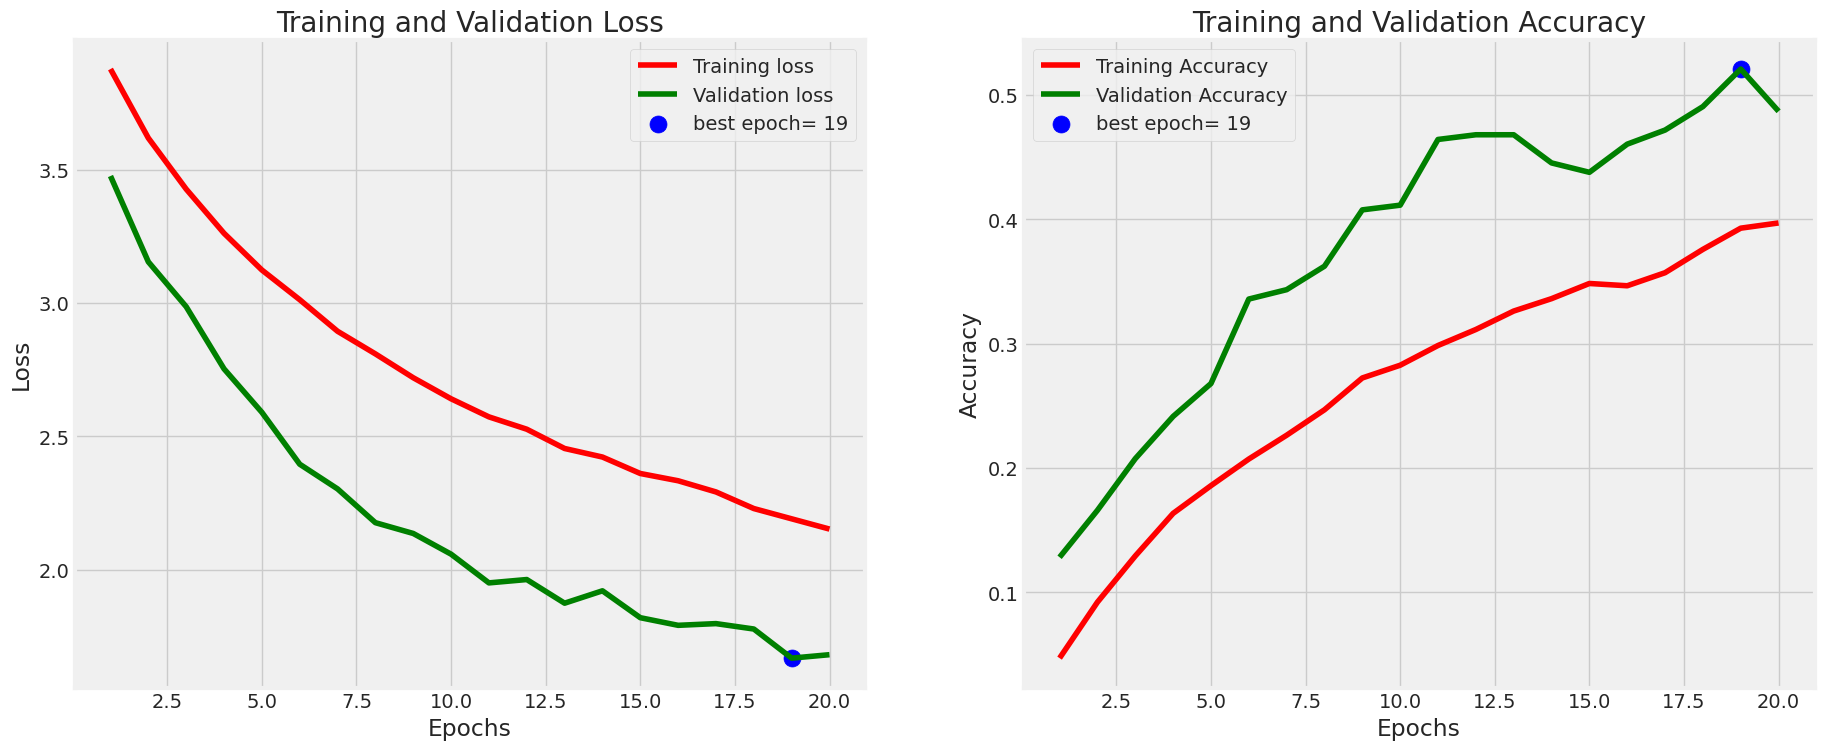

In [ ]:
#Evalute model

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

382/382 ━━━━━━━━━━━━━━━━━━━━ 99s 260ms/step - accuracy: 0.5366 - loss: 1.7143
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5141 - loss: 1.6598
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5005 - loss: 1.7620
Train Loss:  1.7280597686767578
Train Accuracy:  0.5312172174453735
--------------------
Validation Loss:  1.667423963546753
Validation Accuracy:  0.5207546949386597
--------------------
Test Loss:  1.817708134651184
Test Accuracy:  0.47547170519828796


In [ ]:
#get prediction
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step


In [ ]:
model.save('model.h5')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


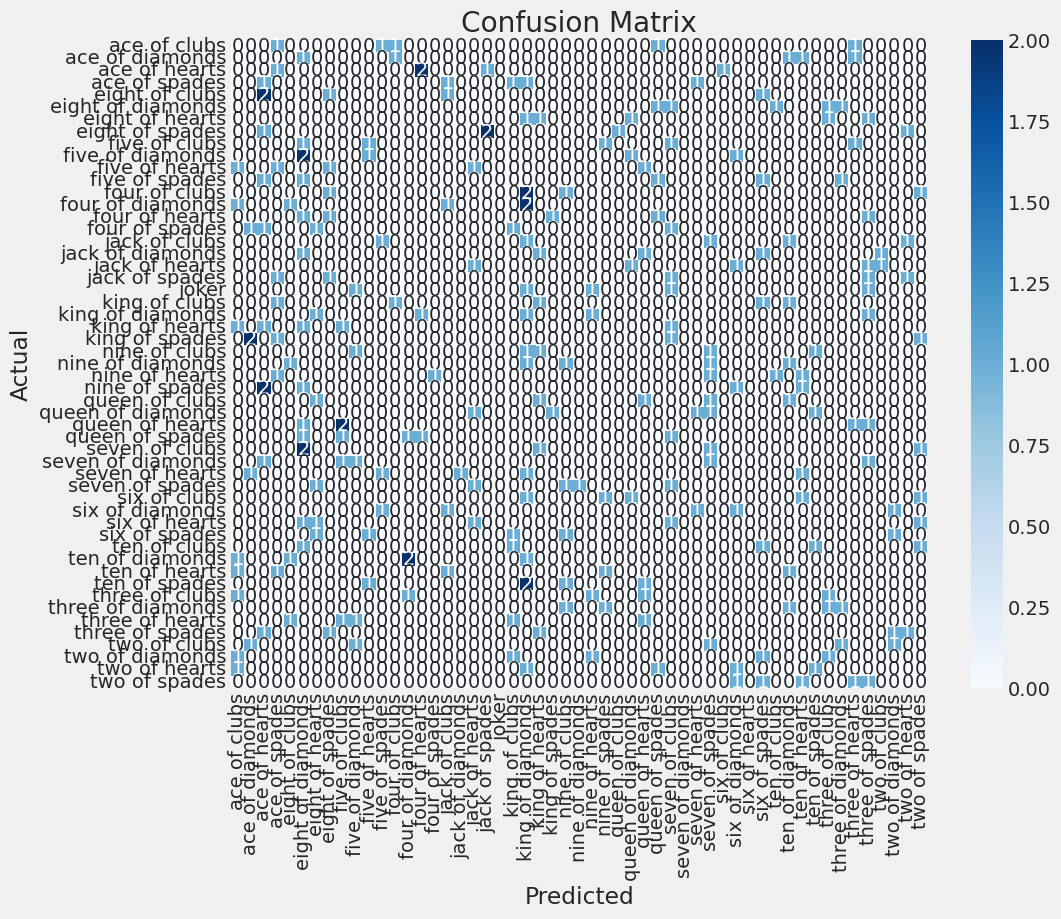

                   precision    recall  f1-score   support

     ace of clubs       0.00      0.00      0.00         5
  ace of diamonds       0.00      0.00      0.00         5
    ace of hearts       0.00      0.00      0.00         5
    ace of spades       0.00      0.00      0.00         5
   eight of clubs       0.00      0.00      0.00         5
eight of diamonds       0.00      0.00      0.00         5
  eight of hearts       0.00      0.00      0.00         5
  eight of spades       0.00      0.00      0.00         5
    five of clubs       0.00      0.00      0.00         5
 five of diamonds       0.00      0.00      0.00         5
   five of hearts       0.00      0.00      0.00         5
   five of spades       0.00      0.00      0.00         5
    four of clubs       0.00      0.00      0.00         5
 four of diamonds       0.00      0.00      0.00         5
   four of hearts       0.00      0.00      0.00         5
   four of spades       0.00      0.00      0.00       

In [ ]:
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


In [ ]:
from tensorflow.keras.preprocessing import image
from IPython.display import Image as IPImage, display
import numpy as np

def predict_card(model, img_path, train_gen, image_size=(224, 224), threshold=0.5):
    # Resmi yükle ve modele uygun hale getir
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Tahmin yap
    prediction = model.predict(img_array)[0]

    # Doğru sırada class label listesi oluştur
    label_list = [label for label, _ in sorted(train_gen.class_indices.items(), key=lambda item: item[1])]

    # En yüksek olasılığı bul
    top_idx = np.argmax(prediction)
    top_label = label_list[top_idx]
    top_conf = prediction[top_idx]

    print("\n Most similar prediction among all cards:")
    for i, conf in enumerate(prediction):
        print(f"{label_list[i]}: {conf:.3f}")

    if top_conf > threshold:
        print(f"\n✅ Model acc is good for understanding: {top_label} ({top_conf:.2f})")
    else:
        print(f"\n⚠️ Mode is not true: {top_label} ({top_conf:.2f})")

    display(IPImage(filename=img_path))

    return top_label, top_conf


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

 Most similar prediction among all cards:
ace of clubs: 0.043
ace of diamonds: 0.250
ace of hearts: 0.014
ace of spades: 0.089
eight of clubs: 0.020
eight of diamonds: 0.006
eight of hearts: 0.003
eight of spades: 0.009
five of clubs: 0.014
five of diamonds: 0.009
five of hearts: 0.007
five of spades: 0.014
four of clubs: 0.012
four of diamonds: 0.003
four of hearts: 0.016
four of spades: 0.026
jack of clubs: 0.011
jack of diamonds: 0.005
jack of hearts: 0.002
jack of spades: 0.011
joker: 0.002
king of clubs: 0.015
king of diamonds: 0.007
king of hearts: 0.001
king of spades: 0.002
nine of clubs: 0.010
nine of diamonds: 0.005
nine of hearts: 0.038
nine of spades: 0.021
queen of clubs: 0.004
queen of diamonds: 0.005
queen of hearts: 0.012
queen of spades: 0.007
seven of clubs: 0.002
seven of diamonds: 0.005
seven of hearts: 0.011
seven of spades: 0.026
six of clubs: 0.011
six of diamonds: 0.005
six of hearts: 0.002
six of spades: 0.008
ten of clubs

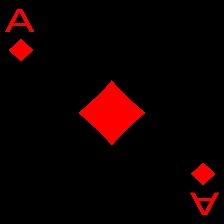

In [ ]:
label, confidence = predict_card(model, '/content/cards-image-datasetclassification/valid/ace of diamonds/2.jpg', train_gen)